In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/train'
validation_dir = 'C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/valid'

batch_size = 30
img_size = 224

train_datagen = ImageDataGenerator(rescale=1/255)

# train_datagen = ImageDataGenerator(rescale=1/255,
#                                    rotation_range=20,  # 지정된 각도 범위내에서 임의로 원본 이미지를 회전
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    zoom_range=0.1,    #  1-수치 혹은 1+수치만큼 확대 및 축소
#                                    horizontal_flip=True,
#                                    vertical_flip=True)



validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),                      
    batch_size=batch_size,     
    class_mode='categorical'                    
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size,img_size),                       
    batch_size=batch_size,    
    class_mode='categorical'                    
)

Found 25461 images belonging to 10 classes.
Found 6371 images belonging to 10 classes.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet101

np.random.seed(42)

# 모델 구축

# InceptionResNetV2 모델 불러오기
pre_trained_model = ResNet101(include_top=False, weights='imagenet',
                                  input_shape=(img_size, img_size, 3))
pre_trained_model.trainable = False
pre_trained_model.summary()

# InceptionResNetV2 모델에 덧붙이기
model = Sequential()
model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 68,390,346
Trainable params: 25,732,170
Non-trainable params: 42,658,176
___________________________________

In [3]:
early_stopping = EarlyStopping(patience = 3) # 조기종료 콜백함수 정의

# 데이터 개수 / batch_size
steps_per_epoch = 25461 / batch_size
val_steps = 6371 / batch_size

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/30
849/848 [==============================] - 829s 976ms/step - loss: 0.5159 - accuracy: 0.8592 - val_loss: 0.2718 - val_accuracy: 0.9214
Epoch 2/30
849/848 [==============================] - 826s 973ms/step - loss: 0.2788 - accuracy: 0.9179 - val_loss: 0.2341 - val_accuracy: 0.9309
Epoch 3/30
849/848 [==============================] - 829s 976ms/step - loss: 0.2501 - accuracy: 0.9264 - val_loss: 0.2554 - val_accuracy: 0.9250
Epoch 4/30
849/848 [==============================] - 827s 974ms/step - loss: 0.2249 - accuracy: 0.9325 - val_loss: 0.2473 - val_accuracy: 0.9303
Epoch 5/30
849/848 [==============================] - 827s 974ms/step - loss: 0.2012 - accuracy: 0.9384 - val_loss: 0.1757 - val_accuracy: 0.9463
Epoch 6/30
849/848 [==============================] - 827s 974ms/step - loss: 0.1882 - accuracy: 0.9426 - val_loss: 0.2326 - val_accuracy: 0.9314
Epoch 7/30
849/848 [==============================] - 828s 976ms/step - loss: 0.1822 - accuracy: 0.9448 - val_loss: 0.1860 -

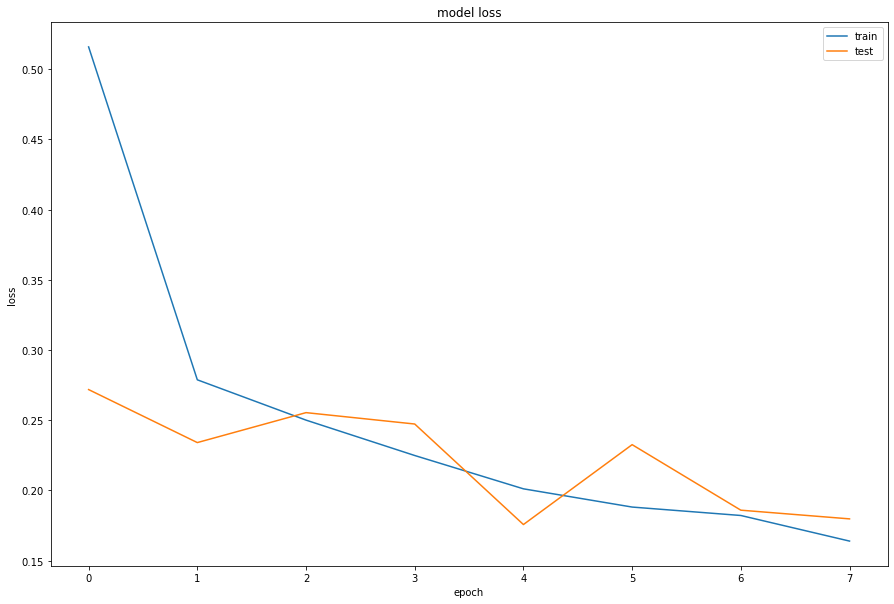

train loss= 0.16394828259944916
validation loss= 0.17976988852024078


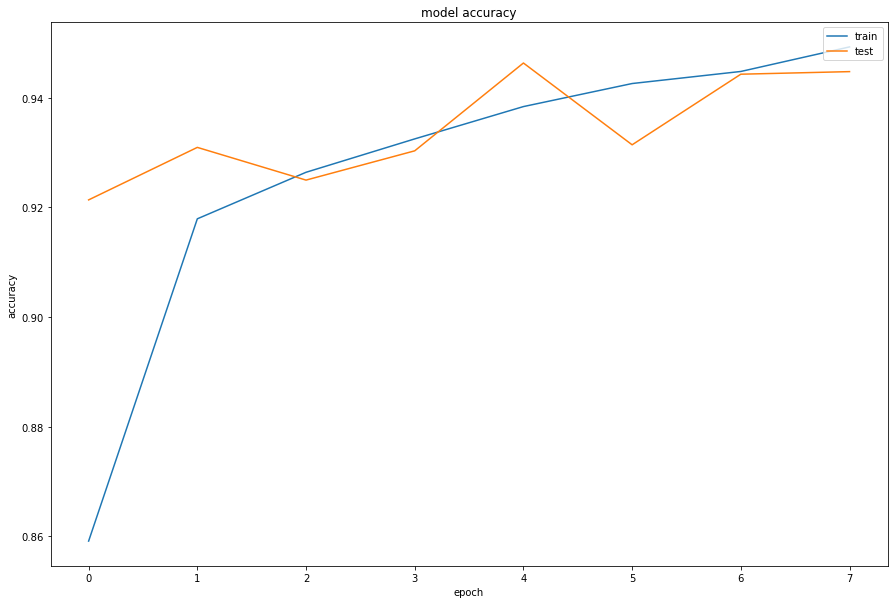

train accuracy= 0.9492557048797607
validation accuracy= 0.944749653339386


In [4]:
# 학습 곡선을 나타내는 함수
def plot_loss_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train loss=", history.history['loss'][-1])
    print("validation loss=", history.history['val_loss'][-1])
    
def plot_acc_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train accuracy=", history.history['accuracy'][-1])
    print("validation accuracy=", history.history['val_accuracy'][-1])
    
plot_loss_curve(history)
plot_acc_curve(history)

In [8]:
model.save('C:/Users/s_csmscox/jupyterSave/kFashion/InceptionResNetV2_256.h5')

In [7]:
import pathlib
import os,glob
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical

directory = 'C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test'
categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
nb_classes = len(categories)

img_size = 224

w = img_size
h = img_size

X = []
y = []

for idx, obj in enumerate(categories):

    image_dir = directory + "/" + obj
    files = glob.glob(image_dir+"/*.jpg")
    print(obj, " 파일 길이 : ", len(files))
    
    for i, f in enumerate(files):
        img = Image.open(f)
        
        # 사이즈 조절
        img = img.resize((w, h))
        
        img = np.asarray(img)
        img = img.reshape(w,h,3)

        X.append(img)
        y.append(idx)

        if i % 10000 == 0:
            print(obj, " : ", f)
            
X_test = np.array(X)
X_test = X_test / 255

y_test = np.array(y)
y_test = to_categorical(y_test)

0  파일 길이 :  3081
0  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/0\10003.jpg
1  파일 길이 :  1845
1  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/1\10035.jpg
2  파일 길이 :  611
2  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/2\10202.jpg
3  파일 길이 :  538
3  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/3\10018.jpg
4  파일 길이 :  887
4  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/4\10106.jpg
5  파일 길이 :  362
5  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/5\13564.jpg
6  파일 길이 :  215
6  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/6\14907.jpg
7  파일 길이 :  187
7  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/7\12441.jpg
8  파일 길이 :  140
8  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/8\12393.jpg
9  파일 길이 :  96
9  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/9\10360.jpg


In [8]:
# 모델 평가
print("-- Evaluate --")
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
249/249 [==============================] - 25s 102ms/step - loss: 0.1782 - accuracy: 0.9470
accuracy: 94.70%


In [7]:
from sklearn.metrics import classification_report

n = 10

#y_pred와 y_test를 일차원 배열로 만 드는 함수
def y_to_list(y_pred, y_test):
    yp = []
    yt = []
    for i in y_pred:
        idx = 0
        m = 0
        for j in range(0,n):
            if(i[j]>m):
                m = i[j]
                idx = j
        yp.append(idx)
    
    for i in y_test:
        idx = 0
        for j in range(0,n):
            if(i[j]==1):
                idx = j
                break
        yt.append(idx)
    
    return yp, yt

#모델 예측 및 classification_report를 통한 평가
y_pred = model.predict(X_test)

yp, yt = y_to_list(y_pred, y_test)

print(classification_report(yt, yp))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3081
           1       1.00      1.00      1.00      1845
           2       0.98      0.99      0.98       611
           3       0.99      0.99      0.99       538
           4       1.00      1.00      1.00       887
           5       0.97      0.97      0.97       362
           6       0.99      1.00      1.00       215
           7       0.96      0.92      0.94       187
           8       1.00      0.98      0.99       140
           9       0.78      0.77      0.77        96

    accuracy                           0.99      7962
   macro avg       0.97      0.96      0.96      7962
weighted avg       0.99      0.99      0.99      7962



In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('C:/Users/s_csmscox/jupyterSave/kFashion/kFashion/train/0/4oqq8cs933.jpg')

img_size = 299

img = img.resize((img_size,img_size))
        
img = np.asarray(img)
img = img.reshape(img_size,img_size,3)

plt.imshow(img)
plt.show()

img = img/255

img = img.reshape(1,img_size,img_size,3)
pred = model.predict(img)

for i in pred:
    m = i.max()
    for j in range(10):
        if i[j] == m:
            if j == 0:
                print("예측 : Topwear")
            elif j == 1:
                print("예측 : Shoes")
            elif j == 2:
                print("예측 : Bags")
            elif j == 3:
                print("예측 : Bottomwear")
            elif j == 4:
                print("예측 : Accessories")
            elif j == 5:
                print("예측 : Innerwear")
            elif j == 6:
                print("예측 : Eyewear")
            elif j == 7:
                print("예측 : Wallets")
            elif j == 8:
                print("예측 : Socks")
            else:
                print("예측 : Dress")


In [2]:
from tensorflow.keras.models import load_model

model = load_model('C:/Users/s_csmscox/jupyterSave/kFashion/InceptionResNetV2.h5')

In [3]:
#### Fine Tuning

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionResNetV2

np.random.seed(42)

img_size = 299

early_stopping = EarlyStopping(patience = 3) # 조기종료 콜백함수 정의

# 데이터 개수 / batch_size
steps_per_epoch = 25461 / batch_size
val_steps = 6371 / batch_size

# InceptionResNetV2 모델 불러오기
pre_trained_model = InceptionResNetV2(include_top=False, weights='imagenet',
                                  input_shape=(img_size, img_size, 3))
pre_trained_model.trainable = False

set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'conv2d_386':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# 일반적으로 learning_rate를 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-7), loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/30
1274/1273 [==============================] - 881s 692ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0602 - val_accuracy: 0.9863
Epoch 2/30
1274/1273 [==============================] - 873s 685ms/step - loss: 9.8812e-04 - accuracy: 0.9999 - val_loss: 0.0604 - val_accuracy: 0.9863
Epoch 3/30
1274/1273 [==============================] - 883s 693ms/step - loss: 9.1321e-04 - accuracy: 0.9999 - val_loss: 0.0604 - val_accuracy: 0.9863
Epoch 4/30
1274/1273 [==============================] - 864s 678ms/step - loss: 8.4946e-04 - accuracy: 0.9999 - val_loss: 0.0603 - val_accuracy: 0.9863


In [4]:
model.save('C:/Users/s_csmscox/jupyterSave/kFashion/InceptionResNetV2_FT.h5')

In [6]:
from tensorflow.keras.models import load_model

model = load_model('C:/Users/s_csmscox/jupyterSave/kFashion/InceptionResNetV2_224.h5')

In [5]:
import pathlib
import os,glob
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical

directory = 'C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test'
categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
nb_classes = len(categories)

img_size = 299

w = img_size
h = img_size

X = []
y = []

for idx, obj in enumerate(categories):

    image_dir = directory + "/" + obj
    files = glob.glob(image_dir+"/*.jpg")
    print(obj, " 파일 길이 : ", len(files))
    
    for i, f in enumerate(files):
        img = Image.open(f)
        
        # 사이즈 조절
        img = img.resize((w, h))
        
        img = np.asarray(img)
        img = img.reshape(w,h,3)

        X.append(img)
        y.append(idx)

        if i % 10000 == 0:
            print(obj, " : ", f)
            
X_test = np.array(X)
X_test = X_test / 255

y_test = np.array(y)
y_test = to_categorical(y_test)

0  파일 길이 :  3081
0  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/0\10003.jpg
1  파일 길이 :  1845
1  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/1\10035.jpg
2  파일 길이 :  611
2  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/2\10202.jpg
3  파일 길이 :  538
3  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/3\10018.jpg
4  파일 길이 :  887
4  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/4\10106.jpg
5  파일 길이 :  362
5  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/5\13564.jpg
6  파일 길이 :  215
6  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/6\14907.jpg
7  파일 길이 :  187
7  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/7\12441.jpg
8  파일 길이 :  140
8  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/8\12393.jpg
9  파일 길이 :  96
9  :  C:/Users/s_csmscox/jupyterSave/kFashion/kaggle_fashion/test/9\10360.jpg


In [6]:
# 모델 평가
print("-- Evaluate --")
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
249/249 [==============================] - 42s 170ms/step - loss: 0.0499 - accuracy: 0.9873
accuracy: 98.73%


In [7]:
from sklearn.metrics import classification_report

n = 10

#y_pred와 y_test를 일차원 배열로 만 드는 함수
def y_to_list(y_pred, y_test):
    yp = []
    yt = []
    for i in y_pred:
        idx = 0
        m = 0
        for j in range(0,n):
            if(i[j]>m):
                m = i[j]
                idx = j
        yp.append(idx)
    
    for i in y_test:
        idx = 0
        for j in range(0,n):
            if(i[j]==1):
                idx = j
                break
        yt.append(idx)
    
    return yp, yt

#모델 예측 및 classification_report를 통한 평가
y_pred = model.predict(X_test)

yp, yt = y_to_list(y_pred, y_test)

print(classification_report(yt, yp))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3081
           1       1.00      1.00      1.00      1845
           2       0.97      0.99      0.98       611
           3       0.99      0.99      0.99       538
           4       1.00      1.00      1.00       887
           5       0.97      0.97      0.97       362
           6       1.00      1.00      1.00       215
           7       0.96      0.91      0.93       187
           8       1.00      0.99      0.99       140
           9       0.77      0.75      0.76        96

    accuracy                           0.99      7962
   macro avg       0.96      0.96      0.96      7962
weighted avg       0.99      0.99      0.99      7962

